In [30]:
import argparse
import traceback
import time
import shutil
import logging
import yaml
import sys
import numpy as np
import copy
import os, glob, pickle
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# folderOne = "AutomotiveProperAlignment1"
# folderOne = "Every10SimultaneousMethod"
folderOne = "actualbaselinesamefraction"
# folderOne = "AutomotiveAllForOne3"
# folderTwo = "AutomotiveFixedAttempt2"
# folderTwo = "AutomotiveAllForOneControlled4"
# folderTwo = "FortyNineTests"
folderTwo = ""

import random

random.seed(10)

In [45]:


loadLocation = folderOne
allFiles = glob.glob(os.path.join(loadLocation+'/densification_result', '*.pth'))
allTargets = glob.glob(os.path.join(loadLocation+'/densification_target', '*.pth'))
# print(os.path.join(loadLocation+'/densification_result', '.pth'))
exampleFile = allFiles[0]
exampleFile = exampleFile.split('/')[-1]
allFileNums = []
allSettingNums = []
largestFileNum = len(allFiles)
smallestFileNum = 0
# for tempFile in allFiles:
#     tempFile = tempFile.split('/')[-1]
#     plzSplit = tempFile.split('_')[0]
#     plzSplit2 = tempFile.split('_')[1]
#     allFileNums.append(int(plzSplit2))
#     allSettingNums.append(int(plzSplit))
# largestFileNum = np.max(allFileNums)
# smallestFileNum = np.min(allFileNums)
largestSettingNum = 1
smallestSettingNum = 0
print("argest is")
print(largestFileNum)
print(smallestFileNum)

batchNum = 1
actualBatchNum = 1
batchMod = batchNum // actualBatchNum
totalDistanceError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalPixels = np.zeros(actualBatchNum)
totalOriginDistances = np.zeros(actualBatchNum)

#For varying 
# full_list = glob.glob(os.path.join(loadLocation, '*GT_completion_897.pth.npy'))
# largestFileNum = len(full_list) - 1
# smallestFileNum = 0
# time_list = glob.glob(os.path.join(loadLocation, '*0_*__TimeTaken.npy'))
# timeArray = []
# for time in time_list:
#     timeArray.append(np.load(time).astype(float))
# sortIndices = np.argsort(np.array(timeArray)).astype(int)
# print(sortIndices)
# print(sortIndices.shape)
# print(time_list.shape)
# sortedList = np.array(time_list)[sortIndices]
# currentCount = -1
print("biggest")
print(largestFileNum)
print(smallestFileNum)
# totalTELEA_error = np.zeros(actualBatchNum)
totalNS_error = np.zeros(actualBatchNum)
# totalTELEA_error_intensity = np.zeros(actualBatchNum)
totalNS_error_intensity = np.zeros(actualBatchNum)
totalINTER_CUBIC_error = np.zeros(actualBatchNum)
totalINTER_NEAREST_error = np.zeros(actualBatchNum)
totalINTER_CUBIC_error_intensity = np.zeros(actualBatchNum)
totalINTER_NEAREST_error_intensity = np.zeros(actualBatchNum)
nearestStackDist = []
nearestStackInt = []
lidargenStackDist = []
gtStackDist = []
inputStackDist = []
for file_num in range(largestFileNum - smallestFileNum):
# for file_num in range(1):
    channelNum = 2 * batchNum
    file_num = file_num + smallestFileNum
    print("FILE NUM IS")
    print(file_num)
    # if(file_num != 4):
    #     continue
    file_name = allFiles[file_num]
    target_name = allTargets[file_num]
    print(file_name)
    # file_name = file_name.split('/')[-1][1:-15]
    print(target_name)
    # if(os.path.isfile(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy') == False):
    #     print(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy')
    #     print("does note xist")
    #     continue
    # GTPath = loadLocation + '/' + str(0) + file_name + '__GT_completion_897.pth.npy'
    # InputPath = loadLocation + '/' + str(0)  + file_name + '__Input_completion_897.pth.npy'
    # GTPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_GT_completion_897.pth.npy'
    # InputPath = loadLocation + '/' + str(0)  + '_' + str(file_num) + '_Input_completion_897.pth.npy'
    GTPath = str(target_name)
    GT = np.reshape(torch.load(GTPath).cpu().numpy(),(channelNum,64,1024))
    print("how many, and how much")
    print(np.max(GT))
    print(np.sum(GT >= 1))
    # GT = np.where(GT >= 1, 0, GT)
    # np.clip(GT,0.0001,1)
    # Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
    # Input = np.where(Input >= 1, 0, Input)
    # np.clip(Input,0.0001,1)
    # print(np.sum(GT))
    # print(np.sum(Input))
    GTdistance = GT[:batchNum]
    print("IT WAS")
    print(GTdistance.shape)
    # GTdistance = np.expand_dims(torch.load(GTPath).cpu().numpy()[0],0)
    print(GTdistance.shape)
    loggedIgnore = 0.1
    # loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
    GTdistance = np.exp2(GTdistance*6)-1
    # GTdistance = np.clip(GTdistance,0.0001,2000)
    # GTdistance = np.where(GTdistance == 2000, 0.0001,GTdistance)
    # mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
    # mask = GTdistance <= loggedIgnore
    # mask = Input[:batchNum] >= 0.001
    #If I just want to compare ALL points and... see what happens?
    mask = np.ones_like(GTdistance, dtype=bool)
    # mask[:,0:10] = 0
    # mask = np.logical_and(GTdistance > 0.5, GTdistance < 63)
    # mask = Input[:batchNum] <= 0.001
    # mask = base_mask
    # mask = np.logical_not(mask)
    # inputMask = np.logical_and(Input[:batchNum] > 0.1, GTdistance < 63)
    inputMask = np.zeros_like(mask)
    inputMask[3::4] = 1
    # print("MASK SHAPE")
    # print(mask.shape)
    # print("TRUE SAN CHECK")
    # print(np.sum(Input[0][inputMask[0]] - GT[0][inputMask[0]]))
    # print(np.sum(Input[0] == GT[0]))
    for multiplier in range(batchNum // actualBatchNum):
        for j in range(actualBatchNum):
            k = actualBatchNum*multiplier + j
            totalPixels[j] += np.sum(mask[k])
    GTintensity = GT[batchNum:]
    # print(GT.shape)
    # print(Input.shape)
    # GTdistance = np.where(mask,GTdistance,0)
    # GTintensity =np.where(mask,GTintensity,0)
    # InputDist = np.float32(Input[:batchNum])
    # InputIntensity = np.float32(Input[batchNum:])
    # InputDist = np.power(2,InputDist*6)-1
    gtStackDist.append(GTdistance)
    # tempInputdistance = np.power(2,InputDist*6)-1
    # tempInputdistance = InputDist
    # inputStackDist.append(tempInputdistance)


    for multiplier in range(batchNum // actualBatchNum):
        for subSample in range(actualBatchNum):
                sample = actualBatchNum * multiplier + subSample
                fullSample = actualBatchNum * multiplier + subSample
                DensificationMask = np.zeros_like(GTdistance[sample])
                # DensificationMask[0::4] = 1
                DensificationMask[1::4] = 1
                DensificationMask[2::4] = 1
                DensificationMask[3::4] = 1
                inputToGive = GTdistance[sample] * np.logical_not(DensificationMask)
                NS_Result_temp = cv2.inpaint(inputToGive,DensificationMask.astype(np.uint8),3, flags=0)
                # TELEA_Result_temp = cv2.inpaint(InputDist[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)
                NS_Result_int = cv2.inpaint(GTintensity[sample],DensificationMask.astype(np.uint8),3, flags=0)
                # TELEA_Result_int = cv2.inpaint(InputIntensity[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)

                print("SANITY CHECK TIME")
                print(GTdistance[fullSample][3::4].shape)

                # INTER_NEAREST_Result_temp = cv2.resize(InputDist[fullSample][3::4],(0, 0), (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                # INTER_NEAREST_Result_int = cv2.resize(InputIntensity[fullSample][3::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                # INTER_CUBIC_Result_temp = cv2.resize(InputDist[fullSample][3::4],(0, 0), (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                # INTER_CUBIC_Result_int = cv2.resize(InputIntensity[fullSample][3::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
            
                # result_bc =                 cv2.resize(result_bc,  (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                INTER_NEAREST_Result_temp = cv2.resize(GTdistance[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                INTER_NEAREST_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                INTER_CUBIC_Result_temp = cv2.resize(GTdistance[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                INTER_CUBIC_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)

                nearestStackDist.append(INTER_NEAREST_Result_temp)
                nearestStackInt.append(INTER_NEAREST_Result_int)
            
                # NS_Result_temp = np.clip(NS_Result_temp,0,1)
                # NS_Result_temp = np.power(2,NS_Result_temp*6)-1
                # NS_Result_int = np.clip(NS_Result_int,0,1)

                # INTER_NEAREST_Result_temp = np.clip(INTER_NEAREST_Result_temp,0.0001,2000)
                # INTER_NEAREST_Result_temp = np.power(2,INTER_NEAREST_Result_temp*6)-1
                # INTER_NEAREST_Result_int = np.clip(INTER_NEAREST_Result_int,0,1)

                # INTER_CUBIC_Result_temp = np.clip(INTER_CUBIC_Result_temp,0.0001,2000)
                # INTER_CUBIC_Result_temp = np.power(2,INTER_CUBIC_Result_temp*6)-1
                # INTER_CUBIC_Result_int = np.clip(INTER_CUBIC_Result_int,0,1)
                # TELEA_Result_temp = np.clip(TELEA_Result_temp,0,1)
                # TELEA_Result_int = np.clip(TELEA_Result_int,0,1)
                # TELEA_Result_temp = np.power(2,TELEA_Result_temp*6)-1
                # print("sanity check")
                # print(np.sum(InputIntensity[sample] > 1))
                # print(np.sum(TELEA_Result_int > 1))
                # print(np.sum(NS_Result_int > 1))
                # print(np.sum(GTintensity > 1))
                      
                
                # totalTELEA_error[subSample] += np.sum(np.absolute(TELEA_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalNS_error[subSample] += np.sum(np.absolute(NS_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                # totalTELEA_error_intensity[subSample] += np.sum(np.absolute(TELEA_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
                totalNS_error_intensity[subSample] += np.sum(np.absolute(NS_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )

    
                totalINTER_CUBIC_error[subSample] += np.sum(np.absolute(INTER_CUBIC_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_CUBIC_error_intensity[subSample] += np.sum(np.absolute(INTER_CUBIC_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
            
                totalINTER_NEAREST_error[subSample] += np.sum(np.absolute(INTER_NEAREST_Result_temp - GTdistance[fullSample]) )
                totalINTER_NEAREST_error_intensity[subSample] += np.sum(np.absolute(INTER_NEAREST_Result_int - GTintensity[fullSample]) )

    #Get the distance between origins
    # toWorld = np.squeeze(np.load(loadLocation + "/toWorld"+ file_name + "_.npy"))
    # fromWorld = np.squeeze(np.load(loadLocation + "/fromWorld"+ file_name + "_.npy"))
    # toWorld = np.expand_dims(np.squeeze(np.load(loadLocation + "/toWorld"+ file_name + "_.npy")),0)
    # fromWorld = np.expand_dims(np.squeeze(np.load(loadLocation + "/fromWorld"+ file_name + "_.npy")),0)
    # baseLine = np.array([0,0,0,1])
    # origins = np.matmul(toWorld, baseLine)
    # initialOrigin = np.matmul(np.linalg.inv(fromWorld), baseLine)
    # print(np.absolute(origins - initialOrigin))
    # origins = origins - initialOrigin
    # origins = np.absolute(origins[:,:3])
    # distances = np.sqrt(origins[:,0]*origins[:,0] + origins[:,1]*origins[:,1] + origins[:,2]*origins[:,2])
    # # print("yessssssss")
    # # print(distances)
    # distances = np.reshape(distances, (batchNum//actualBatchNum, actualBatchNum))
    # totalOriginDistances += np.sum(distances, 0)
    # print(totalOriginDistances)

    for setting_num in range(1):
        loadNum = setting_num + smallestSettingNum
        # maskedPath = loadLocation +'/' + str(loadNum) + file_name + '__Masked_completion_897.pth.npy'
        maskedPath = file_name
        print(maskedPath)
        # numberOfOutputs = (setting_num + 2)
        numberOfOutputs = 1
        if(setting_num == 1):
            numberOfOutputs = actualBatchNum 
        actualChannelNum = numberOfOutputs*batchMod * 2
        # print("NUMBER OF FUCKING INPUTS")
        # print(numberOfInputs)
        # print(largestSettingNum)
        # print("setting")
        # print(setting_num)
        # mask = base_mask[:actualChannelNum]
        # inputMask = inputMask_base[:actualChannelNum]
        # sharedPath = loadLocation +'/' + str(setting_num) + '_' + str(file_num) + '_Masked_Shared_completion_897.pth.npy'
        prediction = np.reshape(torch.load(maskedPath).cpu().numpy(),(actualChannelNum,64,1024))
        # prediction = np.where(prediction >= 1, 0, prediction)
        prediction = np.clip(prediction,0,1)
        # prediction = np.where(prediction >= 2000, 0, prediction)
        # prediction = np.power(2,prediction*6)-1
        # print(np.mean(prediction[:batchNum][mask]))
        # print(np.mean(prediction))
        #no project back up
        distance = prediction[:actualChannelNum//2]
        # print(np.mean(distance))
        distance = np.power(2,distance*6)-1
        # distance = np.clip(distance,0.0001,2000)
        distance =np.where(distance == 2000, 0.0001,distance)
        if(setting_num == 0):
            lidargenStackDist.append(distance)
        # print(np.mean(distance))
        intensity = prediction[actualChannelNum//2:]
        # print("mean is")
        # print(np.mean(distance[mask]))
        
        # distance = np.where(mask,distance,0)
        # intensity =np.where(mask,intensity,0)
        # print(np.mean(distance))
        for multiplier in range(batchNum // actualBatchNum):
            for subSample in range(numberOfOutputs):
                sample = numberOfOutputs * multiplier + subSample
                fullSample = actualBatchNum * multiplier + subSample
                # print(sample)
                distanceError = np.sum(np.absolute(distance[sample][mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )#/ GTdistance[sample][mask[sample]])
                intensityError = np.sum(np.absolute(intensity[sample][mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )#/ GTintensity[sample][mask[sample]])
                # distanceError = np.sum(np.absolute(distance[sample] - GTdistance[fullSample]) )#/ GTdistance[sample][mask[sample]])
                # intensityError = np.sum(np.absolute(intensity[sample] - GTintensity[fullSample]) )#/ GTintensity[sample][mask[sample]])
                distanceErrorInput = np.sum(np.absolute(distance[sample][inputMask[fullSample]] - GTdistance[fullSample][inputMask[fullSample]]) )#/ GTdistance[sample][mask[sample]])
                intensityErrorInput = np.sum(np.absolute(intensity[sample][inputMask[fullSample]] - GTintensity[fullSample][inputMask[fullSample]]) )#/ GTintensity[sample][mask[sample]])
                # print("before")
                print("ERROR")
                print(np.mean(distanceErrorInput))
                # print(totalDistanceErrorInput)
                if(subSample == 0):
                    print(sample)
                    print(distanceErrorInput)
                totalDistanceError[setting_num,subSample] += distanceError
                totalIntensityError[setting_num,subSample] += intensityError
                totalDistanceErrorInput[setting_num,subSample] += distanceErrorInput
                totalIntensityErrorInput[setting_num,subSample] += intensityErrorInput
                totalDistanceInput[setting_num,subSample] += np.sum(distance[sample][inputMask[fullSample]])
                # print(distanceErrorInput)
                # print("after")
                # print(totalDistanceErrorInput )

        # plt.imshow(mask[5])
        # plt.axis('off')
        # plt.show()
        # plt.imshow(np.absolute(GTdistance[5] - distance[5]))
        # plt.axis('off')
        # plt.show()
        # plt.imshow(distance[5])
        # plt.axis('off')
        # plt.show()

totalOriginDistances = totalOriginDistances / ((largestFileNum - smallestFileNum)*batchMod)
print(totalDistanceErrorInput)

argest is
5
0
biggest
5
0
FILE NUM IS
0
actualbaselinesamefraction/densification_result/0000004743.pth
actualbaselinesamefraction/densification_target/0000004743.pth
how many, and how much
1.0
155
IT WAS
(1, 64, 1024)
(1, 64, 1024)
SANITY CHECK TIME
(16, 1024)
actualbaselinesamefraction/densification_result/0000004743.pth
ERROR
0.0
0
0.0
FILE NUM IS
1
actualbaselinesamefraction/densification_result/0000003551.pth
actualbaselinesamefraction/densification_target/0000003551.pth
how many, and how much
1.0
62
IT WAS
(1, 64, 1024)
(1, 64, 1024)
SANITY CHECK TIME
(16, 1024)
actualbaselinesamefraction/densification_result/0000003551.pth
ERROR
0.0
0
0.0
FILE NUM IS
2
actualbaselinesamefraction/densification_result/0000009167.pth
actualbaselinesamefraction/densification_target/0000009167.pth
how many, and how much
1.0
61
IT WAS
(1, 64, 1024)
(1, 64, 1024)
SANITY CHECK TIME
(16, 1024)
actualbaselinesamefraction/densification_result/0000009167.pth
ERROR
0.0
0
0.0
FILE NUM IS
3
actualbaselinesamefr

In [64]:
# distanceAcc = (totalTELEA_error) / (totalPixels+0.000001)
# intensityAcc = (totalTELEA_error_intensity) / (totalPixels+0.000001)
# print(distanceAcc)
# print(intensityAcc)
distanceAcc = (totalNS_error) / (totalPixels+0.000001)
intensityAcc = (totalNS_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_NEAREST_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_NEAREST_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_CUBIC_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_CUBIC_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

[1.85128469]
[0.08854998]
[2.2093106]
[0.104846]
[2.53722248]
[0.11634025]


In [44]:
print(totalPixels)
print(64*1024*8)

[524288.]
524288


In [63]:
print(totalPixels/((largestFileNum - smallestFileNum)*(batchMod)*64*1024))
# print(totalInputPixels/((largestFileNum - smallestFileNum+1)*(batchMod)*64*1024))
# print(totalOriginDistances)
print(totalPixels)
print("Za Input")
# print(largestFileNum)
print(totalDistanceErrorInput)
# totalInputPixels = ((largestFileNum - smallestFileNum+1)*64*1024)*(batchMod) - totalPixels
# print(totalDistanceInput / (totalInputPixels+0.000001))
# print(totalInputPixels/((largestFileNum - smallestFileNum+1)*(batchMod)*64*1024))

# totalDistanceError = np.square(totalDistanceError)
for setting_num in range(largestSettingNum - smallestSettingNum+1):
    loadNum = setting_num + smallestSettingNum
    # distanceAcc = np.sum((totalDistanceError[setting_num])) / np.sum(totalPixels)
    # intensityAcc = np.sum((totalIntensityError[setting_num])) / np.sum(totalPixels)
    # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
    # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
    # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
    # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
    distanceAcc = (totalDistanceError[setting_num]) / (totalPixels+0.000001)
    intensityAcc = (totalIntensityError[setting_num]) / (totalPixels+0.000001)
    # distanceAcc = (totalDistanceError[setting_num][0]) / totalPixels[0]
    # intensityAcc = (totalIntensityError[setting_num][0]) / totalPixels[0]
    # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
    # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
    
    # distanceAccInput = (totalDistanceErrorInput[setting_num]) / (totalInputPixels+0.000001)
    # intensityAccInput = (totalIntensityErrorInput[setting_num]) / (totalInputPixels+0.000001)
    print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))
    # if(setting_num == largestSettingNum - smallestSettingNum ):
    # print("Input: " + str(loadNum) + " Distance is: " + str(distanceAccInput) + " Intensity is : " + str(intensityAccInput))
print("comparing the pair")
# improvement = (totalDistanceError[0][1:] - totalDistanceError[1][1:]) / totalDistanceError[0][1:] 
# print(improvement)
# if(folderTwo != ""):
#     for setting_num in range(largestSettingNum2 - smallestSettingNum2+1):
#         loadNum = setting_num + smallestSettingNum2
#         # distanceAcc = np.sum((totalDistanceError2[setting_num])) / np.sum(totalPixels2)
#         # intensityAcc = np.sum((totalIntensityError2[setting_num])) / np.sum(totalPixels2)
#         # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
#         # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
#         distanceAcc = (totalDistanceError[setting_num]) / totalPixels
#         intensityAcc = (totalIntensityError[setting_num]) / totalPixels
#         # distanceAcc = (totalDistanceError2[setting_num][5:]) / totalPixels2[5:]
#         # intensityAcc = (totalIntensityError2[setting_num][5:]) / totalPixels2[5:]
#         # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
#         # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
#         print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))

# print("comparing the pair")
# # improvement = (totalDistanceError[0][5:] - totalDistanceError[1][5:]) / totalDistanceError[0][5:] 
# print(improvement)

[1.]
[327680.]
Za Input
[[0.]
 [0.]]
Setting: 0 Distance is: [1.43642396] Intensity is : [0.07662683]
Setting: 1 Distance is: [0.] Intensity is : [0.]
comparing the pair


original


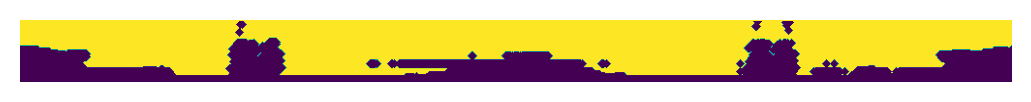

In [87]:
existVals = np.load("existTotal.npy")
import scipy

import matplotlib.pyplot as plt
existVals = existVals > 7
existVals[2:] = scipy.ndimage.binary_erosion(existVals[2:], border_value = 1, iterations=4)
# existVals[:15] = scipy.ndimage.binary_closing(existVals[:15], border_value = 1, iterations=3)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)


%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print("original")

plt.imshow(existVals)
plt.axis('off')
plt.show()

In [25]:
print(allFiles)

['actualbaselineresults/densification_result/0000005436.pth', 'actualbaselineresults/densification_result/0000004743.pth', 'actualbaselineresults/densification_result/0000003551.pth', 'actualbaselineresults/densification_result/0000009167.pth', 'actualbaselineresults/densification_result/0000006196.pth', 'actualbaselineresults/densification_result/0000001904.pth', 'actualbaselineresults/densification_result/0000004106.pth', 'actualbaselineresults/densification_result/0000007538.pth']


actualbaselinesamefraction/densification_result/0000003551.pth


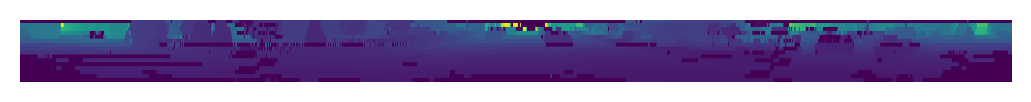

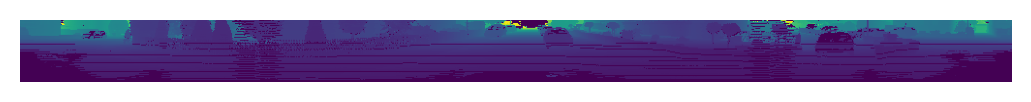

IS same?
570613.9
2210.9426
8.706877
0.000100016594
[10.189037 10.191036 10.193036 10.213035 10.213035 10.251031 10.26503
 10.291029 10.309028 10.329028]
FUUUUUCK YUUUU
42.6364
0.000100016594
8.619171
[8.55917549e+00 8.50918007e+00 8.51117897e+00 8.43518925e+00
 9.73507023e+00 9.66307545e+00 9.67907429e+00 9.62508106e+00
 1.00016594e-04 9.52908707e+00 1.00016594e-04 9.60308075e+00
 9.55508327e+00 9.58308411e+00 1.00016594e-04 1.00016594e-04
 8.58917332e+00 8.49918175e+00 8.46718597e+00 1.00016594e-04
 8.46518707e+00 1.00016594e-04 8.43518925e+00 1.00016594e-04
 8.55117798e+00 1.00016594e-04 1.00016594e-04 1.00016594e-04
 1.00016594e-04 1.00016594e-04 1.00016594e-04 1.00016594e-04
 1.00016594e-04 1.00016594e-04 8.61917114e+00 8.56317520e+00
 1.00016594e-04 1.00016594e-04 1.00016594e-04 1.00016594e-04]


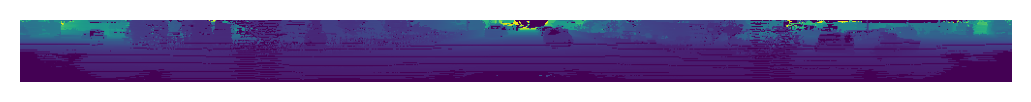

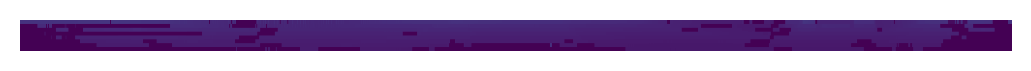

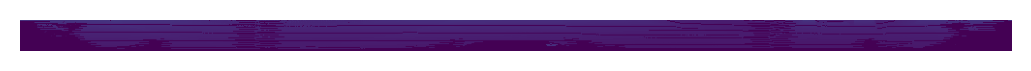

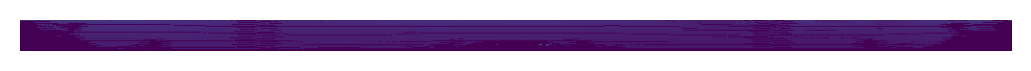

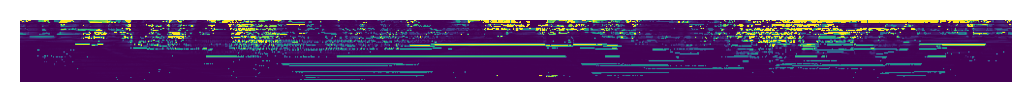

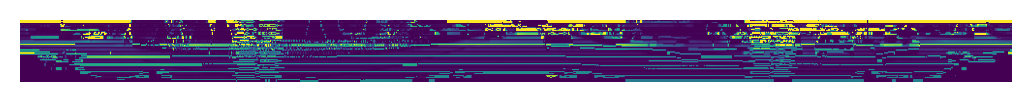

IndexError: list index out of range

In [62]:
max = 64
min = 0
fileNumToUse = 1
print(allFiles[fileNumToUse])
plt.imshow(nearestStackDist[fileNumToUse],vmin=min,vmax=max)
plt.axis('off')
plt.show()

plt.imshow(gtStackDist[fileNumToUse][0],vmin=min,vmax=max)
plt.axis('off')
plt.show()
print("IS same?")
print(np.sum(gtStackDist[fileNumToUse][0]))
print(np.sum(gtStackDist[fileNumToUse][0][30,:300]))
print(np.mean(gtStackDist[fileNumToUse][0]))
print(np.min(gtStackDist[fileNumToUse][0]))
print((gtStackDist[fileNumToUse][0][30,:10]))



print("FUUUUUCK YUUUU")
print(np.sum(gtStackDist[fileNumToUse][0][30,180:210]))
print(np.min(gtStackDist[fileNumToUse][0][30,180:210]))
print(np.max(gtStackDist[fileNumToUse][0][30,180:210]))
print(gtStackDist[fileNumToUse][0][30,160:200])

plt.imshow(lidargenStackDist[fileNumToUse][0],vmin=min,vmax=max)
plt.axis('off')
plt.show()

plt.imshow(nearestStackDist[fileNumToUse][32:],vmin=min,vmax=max)# - gtStackDist[0][0][32:])
plt.axis('off')
plt.show()

plt.imshow(gtStackDist[fileNumToUse][0][32:],vmin=min,vmax=max)
plt.axis('off')
plt.show()

plt.imshow(lidargenStackDist[fileNumToUse][0][32:],vmin=min,vmax=max)#) - gtStackDist[0][0][32:])
plt.axis('off')
plt.show()

plt.imshow(np.absolute(lidargenStackDist[fileNumToUse][0] - gtStackDist[fileNumToUse][0]),vmin=min,vmax=10)
plt.axis('off')
plt.show()

plt.imshow(np.absolute(nearestStackDist[fileNumToUse] - gtStackDist[fileNumToUse][0]),vmin=min,vmax=10)
plt.axis('off')
plt.show()

print(np.mean(inputStackDist[fileNumToUse][0][3::4]))
print(np.mean(gtStackDist[fileNumToUse][0][3::4]))
print(np.mean(lidargenStackDist[fileNumToUse][0][3::4]))

print(np.sum(np.absolute(lidargenStackDist[fileNumToUse][0] - gtStackDist[fileNumToUse][0])))
print(np.sum(np.absolute(nearestStackDist[fileNumToUse] - gtStackDist[fileNumToUse][0])))